# NLP Application: Name Matching/Deduplication

# Introduction

The problem of merging multiple data records into a master record referring to a singular "real-world" entity comes with many names and flavors such as **data linkage, data matching, deduplication, entity resolution, record linkage, data matching, entity disambiguation, object consolidation**, etc. Applications vary from Amazon identifying wether two products are the same, consolidating patient health information, to detecting fraud. It tends to be a fundamental tool to normalizing data in order for it to be "useful". There are a range of approaches and topics on the subject and this will be a brief overview where we explore the topic through consolidating company names.

Below is an image from "Record Linkage: Current Practice and Future Directions" (2003) by Gu et. al that outlines the general anatomy of a matching system. We will touch on each part but note that each block has multiple papers and approaches that vary based on application, domain, and other considerations.

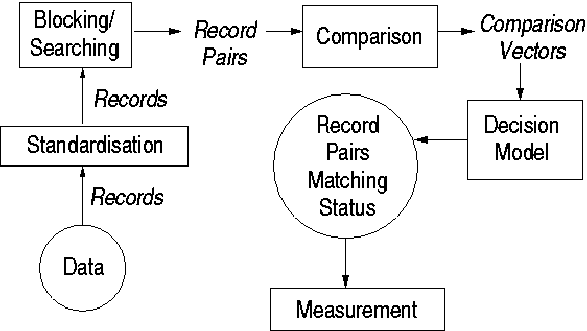

# Data

The data is a snapshot of live companies registered in the UK along with some basic attributes such as address. It is provided by the [Companies House](https://en.wikipedia.org/wiki/Companies_House), which is a government body that maintains the company registers. The data was found here: http://download.companieshouse.gov.uk/en_output.html . [Uniqueness and accuracy](https://www.lexology.com/library/detail.aspx?g=f8d00606-4fb5-43e9-98df-ec896cd4da7d) are part of the expected attributes for such a registry though law has only given authority to fraud and identity check as of 2020. The data is part of their [services](https://www.gov.uk/government/organisations/companies-house/about-our-services#uri-info) in an effort to ["maximise the value of the data held by member organisations, for longer term social and economic benefits"](https://resources.companieshouse.gov.uk/infoAndGuide/faq/publicDataProduct.shtml). Other snapshots and bulk download/data options can be found in services hyperlink previously mentioned.

Below we acquire and inspect the data. Note that this proccess can be complicated by any number of factors from size of the entire set (say amount of websites tagged by Google) to the common issue of having multiple sources of data that don't immediately talk to one another. In this case, it's kept simple in being a single-source, readable file. Usually you want to spend a lot of the time familiarizing with the data to better architect the matching solution, especially in deciding how to preproccess. What's done below is a simple charicature of data analysis.

In [2]:
!wget http://download.companieshouse.gov.uk/BasicCompanyDataAsOneFile-2021-01-01.zip

--2021-01-19 13:25:32--  http://download.companieshouse.gov.uk/BasicCompanyDataAsOneFile-2021-01-01.zip
Resolving download.companieshouse.gov.uk (download.companieshouse.gov.uk)... 194.75.36.68, 62.254.241.68
Connecting to download.companieshouse.gov.uk (download.companieshouse.gov.uk)|194.75.36.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416798024 (397M) [application/zip]
Saving to: ‘BasicCompanyDataAsOneFile-2021-01-01.zip’

BasicCompanyDataAsO 100%[===================>] 397.49M  1.11MB/s    in 6m 18s  

2021-01-19 13:31:51 (1.05 MB/s) - ‘BasicCompanyDataAsOneFile-2021-01-01.zip’ saved [416798024/416798024]



In [5]:
import zipfile
with zipfile.ZipFile("BasicCompanyDataAsOneFile-2021-01-01.zip","r") as zip_ref:
    zip_ref.extractall("company_data_sample")

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
df = pd.read_csv("~/company_data_sample/BasicCompanyDataAsOneFile-2021-01-01.csv")

/Users/gurdit.chahal/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.columns

Index(['CompanyName', ' CompanyNumber', 'RegAddress.CareOf',
       'RegAddress.POBox', 'RegAddress.AddressLine1',
       ' RegAddress.AddressLine2', 'RegAddress.PostTown', 'RegAddress.County',
       'RegAddress.Country', 'RegAddress.PostCode', 'CompanyCategory',
       'CompanyStatus', 'CountryOfOrigin', 'DissolutionDate',
       'IncorporationDate', 'Accounts.AccountRefDay',
       'Accounts.AccountRefMonth', 'Accounts.NextDueDate',
       'Accounts.LastMadeUpDate', 'Accounts.AccountCategory',
       'Returns.NextDueDate', 'Returns.LastMadeUpDate',
       'Mortgages.NumMortCharges', 'Mortgages.NumMortOutstanding',
       'Mortgages.NumMortPartSatisfied', 'Mortgages.NumMortSatisfied',
       'SICCode.SicText_1', 'SICCode.SicText_2', 'SICCode.SicText_3',
       'SICCode.SicText_4', 'LimitedPartnerships.NumGenPartners',
       'LimitedPartnerships.NumLimPartners', 'URI', 'PreviousName_1.CONDATE',
       ' PreviousName_1.CompanyName', ' PreviousName_2.CONDATE',
       ' PreviousName_2.C

In [6]:
df[['CompanyName','RegAddress.AddressLine1',
       ' RegAddress.AddressLine2','RegAddress.PostCode']].head(20)

,CompanyName,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostCode
0,! LIMITED,UNIT 3 NEWTON BUSINESS CENTRE,NEWTON CHAMBERS ROAD,S35 2PH
1,! LTD,METROHOUSE 57 PEPPER ROAD,HUNSLET,LS10 2RU
2,!? LTD,THE STUDIO HATHERLOW HOUSE,HATHERLOW,SK6 3DY
3,!BIG IMPACT GRAPHICS LIMITED,372 OLD STREET,335 ROSDEN HOUSE,EC1V 9LT
4,!L PRODUCTIONS LIMITED,95 MARMION AVENUE,NaN,E4 8EJ
5,!NKED LTD,29 CORRY DRIVE,NaN,SW9 8QS
6,!NNOV8 LIMITED,OLD BARN FARM,HARTFIELD ROAD,TN8 5NF
7,!NSPIRED INVESTMENTS LTD,26 POLMUIR ROAD,NaN,AB11 7SY
8,!NSPIRED LTD,26 POLMUIR ROAD,NaN,AB11 7SY
9,!NVERTD DESIGNS LIMITED,10 PENNARD ROAD,NaN,W12 8DS


In [12]:
len(df)

4837425

In [29]:
from collections import Counter
all_names = df['CompanyName'].apply(lambda name: name.lower()).values
names_freq = Counter()
for name in all_names:
    names_freq.update(str(name).split(" "))
key_words = [word for (word,_) in names_freq.most_common(30)]
print(key_words)

['limited', 'ltd', 'services', '&', 'management', 'the', 'company', 'and', 'solutions', 'property', 'consulting', 'uk', 'group', 'ltd.', 'properties', 'holdings', 'consultancy', 'llp', 'investments', 'construction', 'developments', '(uk)', 'engineering', 'international', 'design', 'london', 'care', 'a', 'of', 'electrical']


Since we're dealing with company names and not sentences or tweets, notice that we don't necessarily have the same expected distribution of "stopwords" , good to keep in mind how langauge and word distribution changes over domains.

In [2]:
df['CompanyName'].value_counts()

DEVON FUEL ASSOCIATES LTD. T/A SERVICETECH SOUTH WEST PARTNERSHIP    10
FOXLEY COURT EQUESTRIAN                                               4
JACK KAY & SONS                                                       3
JAMES MCDOUGALL                                                       3
BONSHAW FARMS                                                         3
                                                                     ..
LOMBARD INVESTMENTS LIMITED                                           1
FARLEY CROFT MANAGEMENT COMPANY LIMITED                               1
IDM DOORS LIMITED                                                     1
FIRST GRAD EVENTS SERVICES LIMITED                                    1
A.J SMARTCHOICE LTD                                                   1
Name: CompanyName, Length: 4836627, dtype: int64

In [16]:
deterministic=df['CompanyName'].value_counts()[df['CompanyName'].value_counts()>=2]
print(len(deterministic))
print(sum(deterministic))

776
1574


The simplest thing we can do is look for exact string matches/[deterministic matching](https://en.wikipedia.org/wiki/Record_linkage#Deterministic_record_linkage). We find 776 such groups with 1574 of the original rows.

# Indexing/Blocking

We don't want to do $\frac{n(n-1)}{2}$ comparasins as this can be very costly and slow. We Can think about ways to "block" chunks of potential pairs to reduce comparasin time. This is similar to the idea of doing a "group by" SQL or pandas operation before applying the comparasin function. Generally we either exploit data from other columns (e.g. block by city) or some knowledge particular to the strings involved (e.g. block by first character in string).

In [7]:
df['StartsWith']=df['CompanyName'].apply(lambda name: name[0])
possible_starts=df['StartsWith'].unique()
possible_starts

array(['!', '"', '#', '$', '&', "'", '(', '*', '+', ',', '-', '.', '/',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=',
       '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
       'X', 'Y', 'Z', '[', '\\', ']', 'e', 'h', 'l', 'm', '{', '£', '¥',
       'À', 'Á', 'Â', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Ï',
       'Ó', 'Ô', 'Õ', 'Ö', 'Ø', 'Ú', 'Ü', 'Ā', 'Č', 'Ē', 'Ģ', 'İ', 'Ō',
       'Ś', 'Ŝ', 'Ş', 'Š', 'Ż', '‘', '“', '€'], dtype=object)

In [9]:
len(possible_starts)

99

In [8]:
df['StartsWith'].value_counts()

S    442006
A    384213
C    373817
T    331192
M    331084
      ...  
Ï         1
Ż         1
m         1
Č         1
=         1
Name: StartsWith, Length: 99, dtype: int64

In [15]:
nsq=df['StartsWith'].value_counts().apply(lambda x: x**2)
n=df['StartsWith'].value_counts()
print("Number of total comparasins after blocking:",((nsq-n)/2).sum())

Number of total comparasins after blocking: 619935162594.0


In [18]:
print("Original number of total comparasins:",(len(df)**2-len(df))/2)

Original number of total comparasins: 11700337896600.0


We note that simply blocking by first letter reduces number of comparasins roughly from and order of $10^{13}$ to an order of $10^{11}$ for total number of comparasins. Blocks can be further reduced with more complicated segmentation rules such as adding postal code restriction (e.g. must be physically in the same vicinity to be considered the same company). What's also important is that now that the blocks are independent in the sense that you can't match across a block, this allows for parallel compuation across machines to further reduce time spent. There are quite a few unexpected characters so need to consider preproccessing first. 

For more sophisticated methods some use a hashing scheme , some discretize after the record vectors have been created, while others stack a series of matching techniques that progress from simple and fast techniques down to accurate but computationally/time expensive matching techniques (more on matching below). A common one that makes use of what we've learned about the ngram vocabulary models, "Q-gram based indexing" where chunks of characters/words of the name are used to search for potentially related company names. In the context of search engines, this is commonly referred to a an "inverted index". See [this classic book on infomation retrieval for more](https://nlp.stanford.edu/IR-book/html/htmledition/a-first-take-at-building-an-inverted-index-1.html). A quick and dirty example using the first 1000 company names is shown below to give a more concrete idea.

In [24]:
import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import snowball
stemmer = snowball.SnowballStemmer('english')

In [25]:
companies= df['CompanyName'].head(1000).values
# This will contain a list of all words in the companies
corpus_words = []

for c in companies:
        word_tokens = word_tokenize(sent)
        corpus_words += word_tokens

len(corpus_words)

3000

In [31]:
inverted_index = defaultdict(set)

# We maintain the reference to the document by its index in the companies list
for docid, c in enumerate(companies):
        for word in word_tokenize(c):
            word_lower = word.lower()
            # ignore words that are in our "stopwords list", the top frequent tokens computed previously
            if word_lower not in key_words:
                word_stem = stemmer.stem(word_lower)
                # We add the company name to the set againt the word in our index
                inverted_index[word_stem].add(docid)

len(inverted_index.keys())

1511

In [32]:
def process_and_search(query):
    matched_documents = set()
    for word in word_tokenize(query):
        word_lower = word.lower()
        if word_lower not in key_words:
            word_stem = stemmer.stem(word_lower)
            matches = inverted_index.get(word_stem)
            if matches:
                matched_documents |= matches
    return matched_documents

In [34]:
process_and_search("investment")

{44, 509}

In [36]:
print(companies[44])
print(companies[509])

"BEDE INVESTMENT PROPERTIES LIMITED"
(IBS) INTERNATIONAL INVESTMENT AND DEVELOPMENT BUSINESS LTD


In [37]:
process_and_search("investment fund")

{44, 77, 446, 509}

In [38]:
print(companies[77])
print(companies[446])

"FIVE TOWNS PLUS" HOSPICE FUND LIMITED(THE)
'THE TRADES WIDOWS' FUND CHARITY


Note that this index doesn't rank relevant company names but does simple matching. One approach is to also weight these results by some sort of scoring, commonly the tf-idf of the documents/company names. Ranking/scoring can further reduce the number of eligible comparasins to make. This is a core idea to the popular [Lucene](https://lucene.apache.org/) and [Elasticsearch](https://www.elastic.co/what-is/elasticsearch) search engine tools.

# Preproccessing/Standardisation

To maximize quality and validity of matches, standardizing is a natural step and often where domain expertise and creativity come into place. The major steps typically involve removing "junk" characters and words, expanding abbreviations/correcting misspellings, segmenting /discretizing attributes (e.g. breaking address down into street , postal code, and town), and verifying attributes used. Here we ignore the other fields besides the name for sake of simplicity and do a general preproccessing step to clean up the company names.

In [2]:
import string as pacString
import re
translationTable = str.maketrans("éàèùâêîôûçáäåæāëìïóõöøúüōśŝşšżčēģ", "eaeuaeioucaaaaaeiioooouuosssszceg")
punctuations = list(pacString.punctuation)

#function for removing and standardizing punctuation
def remove_punctuation(string, punctuations = list(pacString.punctuation)):
    #string = string.replace('&', ' and ')
    string = string.replace(',', ' ')
    string = string.replace('-', ' ')
    keep = ["&"]
    punctuations = [p for p in punctuations if p not in keep]
    rx = '[' + re.escape(''.join(punctuations)) + ']'
    string = re.sub(rx, '', string) #remove the list of chars defined above
    return string

#find chunks/key word segments based on regex pattern and group based on pattern
def find_key_words(string,pattern=None):
    string = str(string)
    if not(pattern):
        pattern = r"\b[A-Za-z]{1,2}\s*&\s*[A-Za-z]{1,2}\b" #combine 1-2 letter standalone characters into single 
    combO = re.findall(pattern,string)
    if len(combO)>0:
        combN = [re.sub(r"\s", "", c) for c in combO]
        for i in range(len(combO)):
            string = string.replace(combO[i], combN[i])
    else:
        combN = []
    #print(comb)
    return combN, string

#clean/preproccess dataframe
def clean_name(df,name_col):
    df[name_col]=df[name_col].apply(lambda name: name.lower())
    df[name_col]=df[name_col].apply(lambda name: remove_punctuation(name, punctuations))
    df[name_col]=df[name_col].apply(lambda name: name.translate(translationTable))
    df[name_col]=df[name_col].apply(lambda name: re.sub(r"\band\b", "&", name))
    df[name_col]=df[name_col].apply(lambda name: find_key_words(name)[1])
    df[name_col]=df[name_col].apply(lambda name: re.sub(' +',' ',name).strip())
    df['StartsWith']=df[name_col].apply(lambda name: name[0])
    return df

In [3]:

clean_df=clean_name(df,name_col='CompanyName')
possible_starts=clean_df['StartsWith'].unique()
possible_starts


array(['l', 'b', 'n', 'o', 'y', '1', '2', '3', '7', 'a', '&', 'c', 'd',
       'e', 'f', 'g', 'h', 'i', 'j', 'k', 'm', 'p', 'q', 'r', 's', 't',
       'u', 'v', 'w', 'z', '4', '8', '0', '5', '6', '9', 'x', '£', '¥',
       '‘', '“', '€'], dtype=object)

In [23]:
deterministic_clean=df['CompanyName'].value_counts()[df['CompanyName'].value_counts()>=2]
print(len(deterministic_clean))
print(sum(deterministic_clean))

1198
2437


In [35]:
deterministic=pd.DataFrame(deterministic)
deterministic['cleaned']=deterministic.index
deterministic=clean_name(deterministic,name_col='cleaned')
new_additions=set(deterministic_clean.index)-set(deterministic['cleaned'])
print(len(new_additions))
print(list(new_additions)[:10])

422
['kitchens uk limited', '87 limited', 'sohoco limited', 'slc consultancy ltd', 'clarke & co limited', 'mm transport ltd', 'cigna life insurance company of europe sa nv', 'you limited', 'alfheim ltd', 'abbey lumber uk limited']


Just through some preproccessing we see how our valid match candidate space grows in the deterministic case. Deterministic matching is essentially the baseline algorithm and we will explore 'fuzzy' algorithms below.

# Comparison and Decision Model

In [87]:
%pip install fuzzy
%pip install python-Levenshtein
%pip install gensim
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


For actual comparasins and scorings to be done ,we will look at some traditional string-based methods beyond deterministic matching as well as a few vector-based methods. Specifically, we will look at:

- [Soundex](https://www.archives.gov/research/census/soundex),

- [Levenshtein Distance/Similarity](https://en.wikipedia.org/wiki/Levenshtein_distance),

- [Jaccard Distance/Similarity](https://en.wikipedia.org/wiki/Jaccard_index),

- [Cosine Distance/Similarity with Tf-Idf](https://en.wikipedia.org/wiki/Cosine_similarity),

- [Word2Vec with Cosine](https://arxiv.org/abs/1301.3781)

## Soundex

The soundex algorithm essentially compares phonetics/sounds of words to attribute a measure of similarity. Essentially letters that sound the same like 'd' and 't' are encoded as the same integer and vowels (unless it's the first character) are dropped. More details can be found [here](https://en.wikipedia.org/wiki/Soundex) with exact implementations varying by library as the algorithm has evolved over time.

In [35]:
import fuzzy
soundex = fuzzy.Soundex(6)
print(soundex('Amazon Co'))

A5252


In [17]:
clean_df['Soundex']=clean_df['CompanyName'].apply(lambda name: soundex(name.encode('utf-8')))

In [18]:
soundex_group=clean_df.groupby('Soundex')['CompanyName']
soundex_group.count()

Soundex
A12112      1
A12121     42
A12122      1
A12123     58
A12124    210
         ... 
Z65626      3
Z65632      1
Z65643      3
Z65645      4
Z65654      2
Name: CompanyName, Length: 92861, dtype: int64

In [19]:
soundex_group.get_group('A12112')

128036    abs seva
Name: CompanyName, dtype: object

In [20]:
soundex_group.get_group('A12121')

86680                         a piece of cake events ltd
86681                      a piece of cake foods limited
90967                          a&a bespoke furniture ltd
105169                             a2b cabs brackley ltd
106775                            aa bespoke fitness ltd
113579                ab wisbech property management ltd
114180                  abacus back office solutions ltd
114186              abacus book keeping scotland limited
114187               abacus book keeping company limited
114188         abacus bookkeeping & payroll services ltd
114189                     abacus bookkeeping uk limited
114190             abacus bookkeeping & accounts limited
114191                 abacus bookkeeping consultant ltd
114192                 abacus bookkeeping london limited
114193               abacus bookkeeping services limited
114194              abacus bookkeeping solutions limited
118793                                abc bespoke qs ltd
118809    abc book keeping & ac

In [21]:
soundex_group.get_group('Z65654')

4824841    zero marine limited
4825342    zerum renew limited
Name: CompanyName, dtype: object

In [50]:
soundex_group.count().describe()

count    92859.000000
mean        52.094304
std         99.477147
min          1.000000
25%          6.000000
50%         19.000000
75%         57.000000
max       4428.000000
Name: CompanyName, dtype: float64

A key observation is soundex has a high rate of fuzzy matches at the cost of a high false positives rate. We are also left to sorth through the $42^2$ possible matches. This is a typical tradeoff alongside speed in terms of this being a relatively fast algorithm. Although "primitive", this algorithm actually provides a solid way of blocking company names for slower, more sophisticated algorithms.

## Levenshtein 

The Levenshtein algorithm is a classic "spell-checking" approach to name comparasins. Refer to the wiki/previous link for details but essentially you keep a score of edits needed to convert one string to another in the form of deleting,adding, or substituting characters. The formula is recursive in nature.

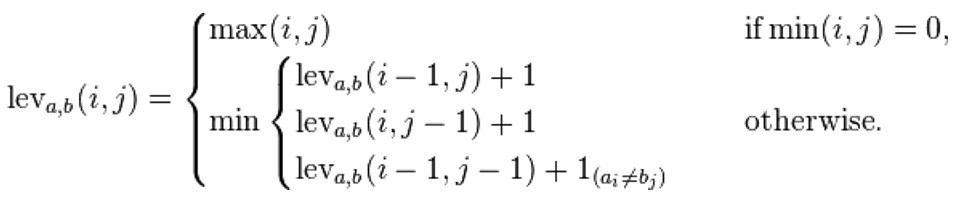

In [31]:
from Levenshtein import ratio as lev_ratio
from Levenshtein import distance as lev_distance

In [34]:
print(lev_distance('Amazon','Amazon Co'))
print(lev_ratio('Amazon','Amazon Co'))

print(lev_distance('Amazon','Amazn'))
print(lev_ratio('Amazon','Amazn'))

3
0.8
1
0.9090909090909091


To get a normalized score rather than raw number of operations needed, we can normalize by the string lengths:

# $\frac{|a|+|b|-lev(a,b)}{|a|+|b|}$ 

Where $|a|$ and $|b|$ are the lengths of the respective strings a and b. Since Levenshtein would be prohibitively slow on our entire dataset. We grab one of the Soundex groups as a subset to test on.

In [37]:
test_group=soundex_group.get_group('A12121')

In [53]:
from scipy.spatial.distance import pdist,squareform
import numpy as np
ratio_vectorize=np.vectorize(lev_ratio)

In [66]:
ratio_matrix=squareform(pdist(test_group.values.reshape(-1,1).astype('str'),ratio_vectorize)) #calculate ratio between all pairs of names
print(ratio_matrix.shape)
ratio_matrix[0,:] #similarity between 'a piece of cake events ltd' and other companies

(42, 42)


array([0.        , 0.76363636, 0.50980392, 0.46808511, 0.54166667,
       0.56666667, 0.51724138, 0.4516129 , 0.42622951, 0.47761194,
       0.43636364, 0.44444444, 0.44067797, 0.40677966, 0.49180328,
       0.4516129 , 0.54545455, 0.44444444, 0.41269841, 0.5       ,
       0.41935484, 0.41666667, 0.46808511, 0.42857143, 0.48979592,
       0.48      , 0.47457627, 0.37209302, 0.33333333, 0.50980392,
       0.43333333, 0.51724138, 0.44897959, 0.44897959, 0.48979592,
       0.47826087, 0.46511628, 0.50793651, 0.50847458, 0.5       ,
       0.48      , 0.48979592])

In [132]:
names=test_group.values
rows,cols=np.where(ratio_matrix-np.tri(*ratio_matrix.shape)>=.7) #set threshold for which we accept the ratio
sims=ratio_matrix[rows,cols]
pd.DataFrame(zip(names[rows],names[cols],sims),columns=['name1','name2','similarity'])

,name1,name2,similarity
0,a piece of cake events ltd,a piece of cake foods limited,0.763636
1,a&a bespoke furniture ltd,aa bespoke fitness ltd,0.808511
2,aa bespoke fitness ltd,abc bespoke qs ltd,0.750000
3,aa bespoke fitness ltd,ap jc bespoke joinery ltd,0.723404
4,abacus back office solutions ltd,abacus bookkeeping solutions limited,0.705882
...,...,...,...
83,aibs bookkeeping limited,avci bookkeeping limited,0.916667
84,ap csip fp gp llp,ap csip gp 1 llp,0.848485
85,apex pe & sport limited,apex vape & cbd limited,0.782609
86,apg bookkeeping limited,avci bookkeeping limited,0.893617


Here we see our search space has become much more tractable as we go from $\frac{42^2*41}{2}=861$ possible pairs to manually sort through to 88. We see an advantage in terms of highly similar names have high matches with variation as in the first row. The downside to the method is that high scores are given to companies that are a few letters apart such as "avci bookkeeping limited" vs "apg bookkeeping limited". Although only a few letters apart, the difference is critical for company names. A similar example is names of people where "Alex" and "Alexa" might be seen as highly similar but for human context would likely be considered completely different names. 

## Jaccard 

With Jaccard we look at comparing strings from a set perspective. Our elements of the set can range from characters to character or word ngrams. Deciding the atomic element will have a large impact on outcome. Character level will look similar to Levenshtein without accounting for position whereas ngrams will be closer to our cosine application that comes after.
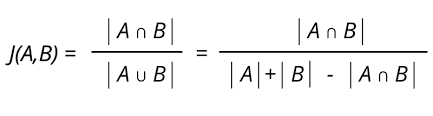

In [101]:
def jaccard_similarity(str1, str2):
    #simple function based on defintion
    s1 = set(str1.split())
    s2 = set(str2.split())
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

jac_vectorize=np.vectorize(jaccard_similarity)

In [102]:
jac_matrix=squareform(pdist(test_group.values.reshape(-1,1).astype('str'),jac_vectorize)) #calculate jaccard similarity between all pairs of names
print(jac_matrix.shape)
jac_matrix[0,:] #similarity between 'a piece of cake events ltd' and other companies

(42, 42)


array([0.        , 0.5       , 0.11111111, 0.11111111, 0.11111111,
       0.1       , 0.1       , 0.        , 0.        , 0.09090909,
       0.        , 0.        , 0.11111111, 0.        , 0.        ,
       0.        , 0.11111111, 0.        , 0.        , 0.09090909,
       0.09090909, 0.        , 0.        , 0.125     , 0.11111111,
       0.        , 0.        , 0.        , 0.        , 0.1       ,
       0.        , 0.1       , 0.        , 0.        , 0.        ,
       0.        , 0.11111111, 0.        , 0.09090909, 0.09090909,
       0.        , 0.        ])

In [130]:
names=test_group.values
rows,cols=np.where(jac_matrix-np.tri(*jac_matrix.shape)>=.7) #set threshold for which we accept the ratio
sims=jac_matrix[rows,cols]
pd.DataFrame(zip(names[rows],names[cols],sims),columns=['name1','name2','jac_similarity'])

,name1,name2,jac_similarity
0,abacus bookkeeping & payroll services ltd,abc bookkeeping & payroll services ltd,0.714286
1,avcap specialty finance spv i ltd,avcap specialty finance spv ii ltd,0.714286


In [131]:
names=test_group.values
rows,cols=np.where(jac_matrix-np.tri(*jac_matrix.shape)>=.5) #set threshold for which we accept the ratio
sims=jac_matrix[rows,cols]
pd.DataFrame(zip(names[rows],names[cols],sims),columns=['name1','name2','jac_similarity'])

,name1,name2,jac_similarity
0,a piece of cake events ltd,a piece of cake foods limited,0.500000
1,abacus book keeping scotland limited,abacus book keeping company limited,0.666667
2,abacus bookkeeping & payroll services ltd,abc bookkeeping & payroll services ltd,0.714286
3,abacus bookkeeping uk limited,abacus bookkeeping & accounts limited,0.500000
4,abacus bookkeeping uk limited,abacus bookkeeping london limited,0.600000
5,abacus bookkeeping uk limited,abacus bookkeeping services limited,0.600000
6,abacus bookkeeping uk limited,abacus bookkeeping solutions limited,0.600000
7,abacus bookkeeping & accounts limited,abacus bookkeeping london limited,0.500000
8,abacus bookkeeping & accounts limited,abacus bookkeeping services limited,0.500000
9,abacus bookkeeping & accounts limited,abacus bookkeeping solutions limited,0.500000


We see how the unigram version is relatively restrictive compared to the previous algorithms and the threshold impact. Again we trade out some false positives at the cost of potential true positives. It will be in the evaluation section where we will see if it's "worth it".

## Cosine 
Instead of phonetics, string structure, or sets, we moved into euclidean space and angles. We are in the context of [vector space models](https://en.wikipedia.org/wiki/Vector_space_model). Note, Jaccard can be seen similarly with binary vectors.

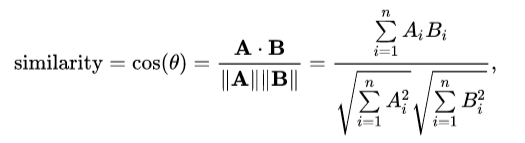

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=2,ngram_range=(1, 2)) #fit tfidf model with unigram and bigrams of word-level tokens
vectorizer.fit(clean_df['CompanyName'])

TfidfVectorizer(min_df=2, ngram_range=(1, 2))

In [123]:
X = vectorizer.transform(test_group.values)
# print(vectorizer.get_feature_names())
arr = X.toarray()

In [124]:
cos_matrix=squareform(pdist(arr,metric='cosine')) #calculate cosine similarity between all pairs of names
print(cos_matrix.shape)
cos_matrix[0,:] #similarity between 'a piece of cake events ltd' and other companies

(42, 42)


array([0.        , 0.28077541, 0.99377143, 0.99570259, 0.99555642,
       0.99367416, 0.99503945, 1.        , 1.        , 0.99567321,
       1.        , 1.        , 0.99492686, 1.        , 1.        ,
       1.        , 0.99409211, 1.        , 1.        , 0.99570341,
       0.99585583, 1.        , 1.        , 0.99379598, 0.99379478,
       1.        , 1.        , 1.        , 1.        , 0.99561925,
       1.        , 0.99544584, 1.        , 1.        , 1.        ,
       1.        , 0.99486391, 1.        , 0.9966749 , 0.99698887,
       1.        , 1.        ])

In [129]:
rows,cols=np.where(cos_matrix+np.tri(*cos_matrix.shape)<=.3) #set threshold for which we accept the ratio, ignore upper triangle since matrix is symmetrc
sims=1-cos_matrix[rows,cols]
pd.DataFrame(zip(names[rows],names[cols],sims),columns=['name1','name2','cos_similarity'])

,name1,name2,cos_similarity
0,a piece of cake events ltd,a piece of cake foods limited,0.719225
1,abacus book keeping scotland limited,abacus book keeping company limited,0.778169
2,abacus bookkeeping uk limited,abacus bookkeeping london limited,0.704182
3,abacus bookkeeping consultant ltd,abacus bookkeeping london limited,0.752178
4,abacus bookkeeping consultant ltd,abacus bookkeeping services limited,0.705698
5,abacus bookkeeping london limited,abacus bookkeeping services limited,0.773641
6,abacus bookkeeping london limited,abacus bookkeeping solutions limited,0.732085
7,abc bookkeeping & accountancy limited,abc bookkeeping & accountancy uk ltd,0.797182
8,aibs bookkeeping limited,apg bookkeeping limited,0.758641
9,ap csip fp gp llp,ap csip gp 1 llp,0.761086


We see for a threshold of .7 for similarity/.3 for distance Cosine finds more true positives than Jaccard and that the scores are a bit more "smooth". We also contextualize word importance and order with tfidf, no longer getting false positives through misspelling like in Levenshtein. The tradeoff is training + computation time as well as not capturing all true positives. Again we can explore character level and so on.

## Word2Vec

Our final pairwise decision algorithm consideration is again a vector space model with Word2Vec. We try to add further word context with semantics to see the effect on matching.


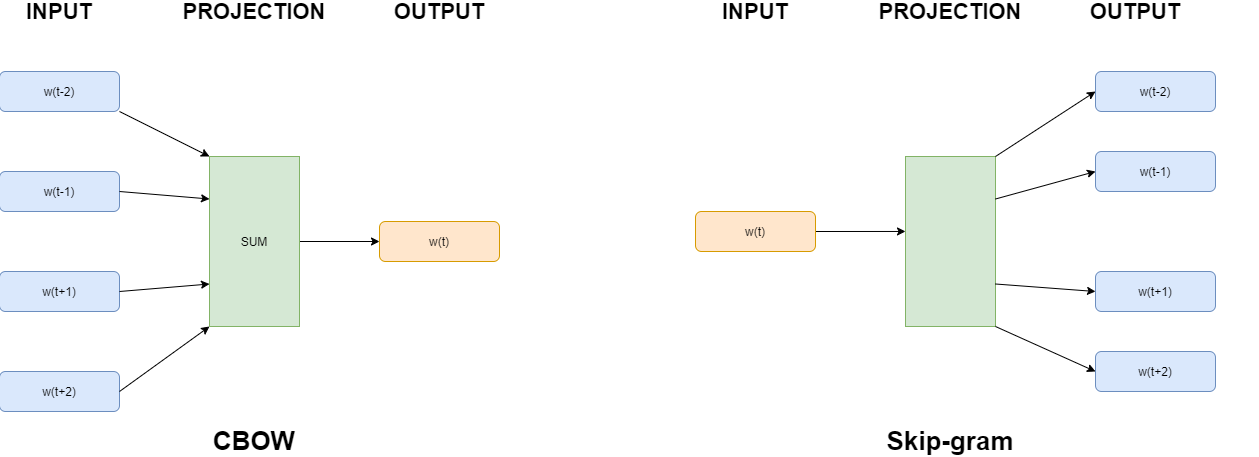
[Sourced From Alpha-Quantum Blog on Word Embeddings](https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/)

In [162]:
training_data=list(clean_df['CompanyName'].apply(lambda name: name.split()).values)

In [167]:
import gensim
from time import time
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [168]:
t=time()
w2vModel = gensim.models.Word2Vec(
        training_data,
        size=160,
        window=10,
        min_count=2,
        workers=4,
        iter=10,
        compute_loss=True, callbacks=[callback()])
print((time()-t)/60)

Loss after epoch 0: 6028801.0
Loss after epoch 1: 4594423.0
Loss after epoch 2: 4293215.0
Loss after epoch 3: 3258587.0
Loss after epoch 4: 2489808.0
Loss after epoch 5: 2449738.0
Loss after epoch 6: 2396004.0
Loss after epoch 7: 2413594.0
Loss after epoch 8: 2416580.0
Loss after epoch 9: 2646324.0
2.0459153135617574


In [209]:
w2vModel.wv.most_similar('limited')

[('ltd', 0.9625943899154663),
 ('llp', 0.6101162433624268),
 ('&', 0.5349342823028564),
 ('cic', 0.37573131918907166),
 ('optymum', 0.3586791157722473),
 ('lp', 0.33563292026519775),
 ('company', 0.3247528672218323),
 ('caterform', 0.29864197969436646),
 ('jbvt', 0.28564149141311646),
 ('mymedia', 0.2788524031639099)]

In [202]:
import numpy as np
from scipy import spatial

index2word_set = set(w2vModel.wv.index2word)

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec



In [206]:
def w2v_cosine(s1,s2,model=w2vModel, num_features=160, index2word_set=index2word_set):
    avg_vector1=avg_feature_vector(s1, model=model, num_features=num_features, index2word_set=index2word_set)
    avg_vector2=avg_feature_vector(s2, model=model, num_features=num_features, index2word_set=index2word_set)
    sim = 1 - spatial.distance.cosine(avg_vector1, avg_vector2)
    return sim
w2v_cosv=np.vectorize(w2v_cosine)
w2v_cosine("a piece of cake events ltd","a piece of cake foods limited")

0.8851425647735596

In [208]:
w2v_matrix=squareform(pdist(test_group.values.reshape(-1,1),w2v_cosv)) #calculate ww2v cossine similarity between all pairs of names
print(w2v_matrix.shape)
w2v_matrix[0,:] #similarity between 'a piece of cake events ltd' and other companies

(42, 42)


array([0.        , 0.88514256, 0.45100793, 0.50132751, 0.42098218,
       0.31257454, 0.42793891, 0.4645153 , 0.47364986, 0.31203294,
       0.28019208, 0.34672418, 0.27246097, 0.33221334, 0.28422293,
       0.23257802, 0.46813977, 0.44660375, 0.34360316, 0.33929724,
       0.33361289, 0.49608663, 0.5409835 , 0.40025863, 0.27623069,
       0.26788938, 0.26943791, 0.19252156, 0.2030151 , 0.32110423,
       0.4627164 , 0.34777823, 0.45102295, 0.47615355, 0.30632022,
       0.47600615, 0.48789477, 0.3300288 , 0.1902028 , 0.12365854,
       0.27437574, 0.3125307 ])

In [210]:
rows,cols=np.where(w2v_matrix-np.tri(*w2v_matrix.shape)>=.7) #set threshold for which we accept the similarity
sims=1-w2v_matrix[rows,cols]
pd.DataFrame(zip(names[rows],names[cols],sims),columns=['name1','name2','w2v_cos_similarity'])

,name1,name2,w2v_cos_similarity
0,a piece of cake events ltd,a piece of cake foods limited,0.114857
1,a&a bespoke furniture ltd,abc bespoke qs ltd,0.192896
2,a&a bespoke furniture ltd,ap jc bespoke joinery ltd,0.239805
3,a&a bespoke furniture ltd,apoc bespoke limited,0.229587
4,a2b cabs brackley ltd,abc buchverlag limited,0.243309
...,...,...,...
114,ap csip gp 1 llp,avcap specialty finance spv ii ltd,0.269094
115,ap jc bespoke joinery ltd,apoc bespoke limited,0.276229
116,apex pe & sport limited,apex vape & cbd limited,0.178270
117,apg bookkeeping limited,avci bookkeeping limited,0.010923


Note we get more than Levenshtein due to semantic fuzzynness. Pro is we see flexibility between words like ltd and limited. Cons is company names with nothing to little to do with each other become seen as potential matches. We may want to try character level or [subword information](https://arxiv.org/abs/1607.04606). Moreover training time and inference time computations become more involved.

# Measurement/Evaluation

For evaluation of a name matching solution, typically the two main pieces that are evaluated are the blocking/indexing scheme and the matching model itself. For pairwise record matching , the typical evaluation metrics used in binary classification are also found here. There are analogous metrics for measuring the blocking/indexing scheme. When grouping pairs, typically we fall under the clustering evaluation regime. For simplicity we stick to pairwise matches for now. Metrics that are critical to practical application but not mentioned here are the speed of the application and memory usage. 

### Blocking Measures
- **Reduction Ratio** 
- **Pair Completeness** 


### Matching Measures
- **Precision/Pairs Quality**
- **Recall**
- **F1-Score**

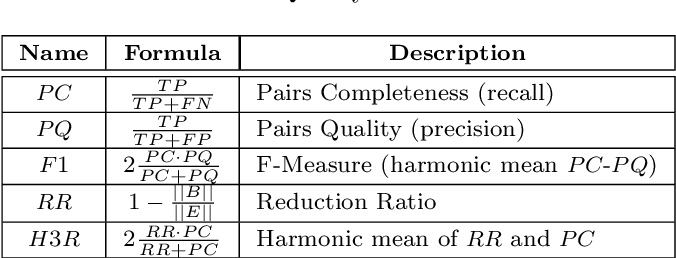

Table from "End-to-End Entity Resolution for Big Data: A Survey" (2020). by CHRISTOPHIDES et. al.

As the original dataset isn't labeled, we take a toy subset from our "test_group" along with 3 synthetic examples and use it as an example for the metrics. We stick to Soundex for blocking, Jaccard for matching and leave computing for the rest to the reader.

In [223]:
golden_set=['avc i bookkeeping limited','avci bookkeeping limited','avci bookkeeping scotland ltd','ap csip fp gp llp','ap csip gp 1 llp','app chop shop ltd','ap chop limited']
golden_set

['avc i bookkeeping limited',
 'avci bookkeeping limited',
 'avci bookkeeping scotland ltd',
 'ap csip fp gp llp',
 'ap csip gp 1 llp',
 'app chop shop ltd',
 'ap chop limited']

In [231]:
from itertools import combinations 

possible_pairs=list(combinations(golden_set, 2)) 
print("Maximum number of pairwise comparisins",len(possible_pairs))
match=np.zeros(len(possible_pairs))

match[0]=1
match[1]=1
match[6]=1
match[15]=1
match[20]=1

names_df=pd.DataFrame(golden_set,columns=['name'])
pairs_df=pd.DataFrame(possible_pairs,columns=['n1','n2'])
pairs_df['match?']=match
pairs_df

Maximum number of pairwise comparisins 21


,n1,n2,match?
0,avc i bookkeeping limited,avci bookkeeping limited,1.0
1,avc i bookkeeping limited,avci bookkeeping scotland ltd,1.0
2,avc i bookkeeping limited,ap csip fp gp llp,0.0
3,avc i bookkeeping limited,ap csip gp 1 llp,0.0
4,avc i bookkeeping limited,app chop shop ltd,0.0
5,avc i bookkeeping limited,ap chop limited,0.0
6,avci bookkeeping limited,avci bookkeeping scotland ltd,1.0
7,avci bookkeeping limited,ap csip fp gp llp,0.0
8,avci bookkeeping limited,ap csip gp 1 llp,0.0
9,avci bookkeeping limited,app chop shop ltd,0.0


In [248]:
#Reduction Ratio, Comparasins Saved
def basic_blocking_count(df,block_col):
    nsq=nsq=df[block_col].value_counts().apply(lambda x: x**2)
    n=df[block_col].value_counts()
    return ((nsq-n)/2).sum()

#Block by first two letters
names_df['first2']=names_df['name'].apply(lambda name: name[:2])
B2=basic_blocking_count(names_df,'first2')
rrB2=1-B2/len(possible_pairs)
print('Reduction Ratio By First Two Letters',rrB2)

#Block by Soundex
names_df['soundex']=names_df['name'].apply(lambda name: soundex(name.encode('utf-8')))
BS=basic_blocking_count(names_df,'soundex')
rrBS=1-BS/len(possible_pairs)
print('Reduction Ratio By Soundex',rrBS)

Reduction Ratio By First Two Letters 0.5714285714285714
Reduction Ratio By Soundex 0.2857142857142857


In [240]:
grp=names_df.groupby('first2')
for name,g in grp:
    print(g['name'].values)

['ap csip fp gp llp' 'ap csip gp 1 llp' 'app chop shop ltd'
 'ap chop limited']
['avc i bookkeeping limited' 'avci bookkeeping limited'
 'avci bookkeeping scotland ltd']


In [241]:
grp=names_df.groupby('soundex')
for name,g in grp:
    print(g['name'].values)

['avc i bookkeeping limited' 'avci bookkeeping limited'
 'avci bookkeeping scotland ltd' 'ap csip fp gp llp' 'ap csip gp 1 llp'
 'app chop shop ltd']
['ap chop limited']


In [250]:
#Pair Completeness, Matches in the Right Blocks
num_true_matches=pairs_df['match?'].sum()
matching_pairs=pairs_df[pairs_df['match?']==1][['n1','n2']].values
print("matching pairs:",matching_pairs)
def basic_completeness(df,block_col,matching_pairs,name_col):
    num_match=0
    grp=df.groupby(block_col)
    for name,g in grp:
        for pair in matching_pairs:
            if set(pair).issubset(set(g[name_col].values)):
                num_match+=1
    return num_match
            
pcB2=basic_completeness(names_df,'first2',matching_pairs,'name')/num_true_matches
pcBS=basic_completeness(names_df,'soundex',matching_pairs,'name')/num_true_matches
print('\n')
print('Pair Completeness By First Two Letters',pcB2)
print('Pair Completeness By Soundex',pcBS)


matching pairs: [['avc i bookkeeping limited' 'avci bookkeeping limited']
 ['avc i bookkeeping limited' 'avci bookkeeping scotland ltd']
 ['avci bookkeeping limited' 'avci bookkeeping scotland ltd']
 ['ap csip fp gp llp' 'ap csip gp 1 llp']
 ['app chop shop ltd' 'ap chop limited']]


Pair Completeness By First Two Letters 1.0
Pair Completeness By Soundex 0.8


In [253]:
#H3R
import scipy
print("H3R First 2 Letters",scipy.stats.hmean([rrB2,pcB2]))
print("H3R Soundex",scipy.stats.hmean([rrBS,pcBS]))

H3R First 2 Letters 0.7272727272727273
H3R Soundex 0.42105263157894735


In [257]:
#We ignore blocking and do the full number of comparasins to see standalone performance
pairs_df['Jac_Sim']=pairs_df.apply(lambda row: jaccard_similarity(row['n1'],row['n2']),axis=1)
pairs_df['50pct_Thresh']=pairs_df['Jac_Sim'].apply(lambda s: 1 if s>=.5 else 0)
pairs_df

,n1,n2,match?,Jac_Sim,50pct_Thresh
0,avc i bookkeeping limited,avci bookkeeping limited,1.0,0.400000,0
1,avc i bookkeeping limited,avci bookkeeping scotland ltd,1.0,0.142857,0
2,avc i bookkeeping limited,ap csip fp gp llp,0.0,0.000000,0
3,avc i bookkeeping limited,ap csip gp 1 llp,0.0,0.000000,0
4,avc i bookkeeping limited,app chop shop ltd,0.0,0.000000,0
5,avc i bookkeeping limited,ap chop limited,0.0,0.166667,0
6,avci bookkeeping limited,avci bookkeeping scotland ltd,1.0,0.400000,0
7,avci bookkeeping limited,ap csip fp gp llp,0.0,0.000000,0
8,avci bookkeeping limited,ap csip gp 1 llp,0.0,0.000000,0
9,avci bookkeeping limited,app chop shop ltd,0.0,0.000000,0


In [259]:
from sklearn.metrics import recall_score,precision_score,f1_score
print("Precision Jaccard:",precision_score(pairs_df['match?'],pairs_df['50pct_Thresh']))
print("Recall Jaccard:",recall_score(pairs_df['match?'],pairs_df['50pct_Thresh']))
print("F1 Jaccard:",f1_score(pairs_df['match?'],pairs_df['50pct_Thresh']))

Precision Jaccard 1.0
Recall Jaccard 0.2
F1 Jaccard 0.33333333333333337


# Limitations/Other Practical Considerations

There are quite a few other topics that branch off from this introduction on name matching. Some major ones worth mentioning that we didn't explore:

- matching on multiple fields, validity and weighting evidence
- multiple data sources normalization/column matching
- runtime and scalability, parallelizing and distributing these algorithms
- ensemble/layered methods that combine the algorithms at different steps
- machine learning to learn blocking/indexing rules
- graph approaches to matching
- unsupervised/unlabeled evaluation
- consolidating pairs into groups via clustering/aggregating knowledge graphs, etc
- deep learning methods on name matching (note: while accurate they usually end up being academic or at the final layer of a matching system)